<a href="https://colab.research.google.com/github/LIVECODING-2025/Saruto/blob/main/Analisis_Sentimen_RandomForeast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORT LIBRARY**

In [1]:
!pip install sastrawi
!pip install swifter
!pip install transformers
!pip install wordcloud
!pip install nltk
!pip install joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16505 sha256=2d4a5304a254fe93d368718da00fa25c8a9a8dbacfa0d2ab86cb11399593853e
  Stored in directory: /root/.cache/pip/wheels/ef/7f/bd/9bed48f078f3ee1fa75e0b29b6e0335ce1cb03a38d3443b3a3
Successfully built swifter


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from tqdm import tqdm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import GridSearchCV
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from transformers import MarianMTModel, MarianTokenizer
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix
from joblib import dump, load
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection

import nltk
import string
import re
import swifter

# **LOAD DATA DARI GOOGLE DRIVE**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
file_id = '/content/drive/MyDrive/Data Science/Live Coding 2025/komentar_berlabel.csv'

In [6]:
df = pd.read_csv(file_id)

In [7]:
label_mapping = {
    0: 'negatif',
    1: 'netral',
    2: 'positif'
}

df['sentiment'] = df['label'].map(label_mapping)

Text(0, 0.5, 'Frekuensi')

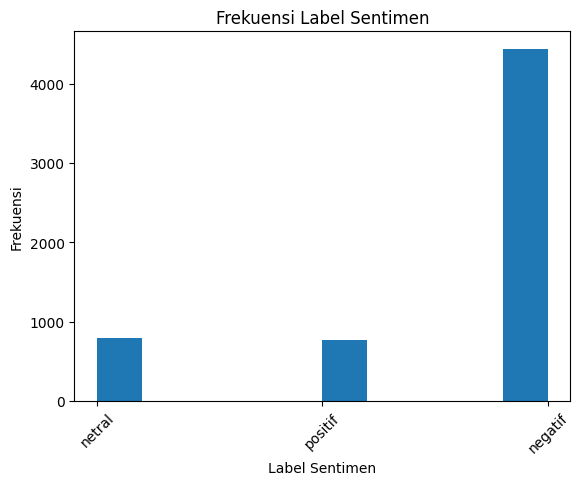

In [10]:
plt.hist(df.sentiment)
plt.xticks(rotation=45)
plt.title('Frekuensi Label Sentimen')
plt.xlabel('Label Sentimen')
plt.ylabel('Frekuensi')

# **PRE-PROCESING**

In [11]:
def remove_emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticon
        u"\U0001F300-\U0001F5FF"  # simbol & pictogram
        u"\U0001F680-\U0001F6FF"  # transport & map symbol
        u"\U0001F1E0-\U0001F1FF"  # flags (bendera)
        u"\U00002700-\U000027BF"  # simbol lainnya
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)


In [12]:
#Cleansing Data
def cleansing(text):
    text = remove_emoji(text) #hapus emoji
    text = re.sub('\[.*?\]', '', text) #Menghilangkan tanda kurung
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Hapus karakter non-alfabet
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #Menghilangkan Tanda Baca
    text = re.sub('\w*\d\w*', '', text) #Menghilangkan Special Karakter
    text = re.sub('\s+[a-zA-Z]\s+', '', text) #Menghilangkan Single Character
    text = re.sub(r"http\S+", "", text, flags=re.MULTILINE) #Menghilangkan Link
    text = re.sub(r'\B#\S+','', text)  #Menghilangkan Hashtag
    text = re.sub(r'\s+', ' ', text, flags=re.I) #Mengganti Multiple Spaces ke Single Spaces
    text = text.strip() #Menghilangkan Spaces di awal
    text = text.translate(str.maketrans('', '', string.punctuation))  # Hapus tanda baca
    return text
df['cleansing']= df['komentar'].apply(lambda x: cleansing(x))

In [13]:
#Tokenizing
def tokenization(text):
    text = re.split('\W+', text)
    return text
df['tokenizing']= df['cleansing'].apply(lambda x: tokenization(x))

In [14]:
#remove stopword pada list token
def stopwords_removal(words):
    # Define the list of stopwords here
    list_stopwords = ['yang', 'di', 'dan', 'itu', 'dengan', 'atau','untuk', 'dari', 'pada'] # Add your stopwords here
    return [word for word in words if word not in list_stopwords]

df['stop removal']= df['tokenizing'].apply(stopwords_removal)

In [15]:
#Stemming
# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stemmed
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

for document in df['stop removal']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '

print(len(term_dict))
print("------------------------")

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    print(term,":" ,term_dict[term])

print(term_dict)
print("------------------------")


# apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict[term] for term in document]

df['stemming'] = df['stop removal'].apply(get_stemmed_term)
df.head()

Streaming output truncated to the last 5000 lines.
MIAWD : miawd
Lha : lha
mahmud : mahmud
cmonnn : cmonnn
bangets : bangets
paks : paks
TEMPE : tempe
sihhhhh : sihhhhh
Ohhh : ohhh
tohhhh : tohhhh
knapa : knapa
Its : its
Funny : funny
gemoyy : gemoyy
bangeytt : bangeytt
bowoooo : bowoooo
Ketularan : tular
MEWAKILI : wakil
NANA : nana
Tulang : tulang
doain : doain
paut : paut
orangacam : orangacam
meresmikan : resmi
Tapiii : tapiii
IFAUU : ifauu
R : r
astagfirullah : astagfirullah
Kakek : kakek
pikunNPDbaby : pikunnpdbaby
boomers : boomers
PLONGA : plonga
PLONGO : plongo
BISANYA : bisa
WKWKWKW : wkwkwkw
NGANDALIN : ngandalin
WKWKWK : wkwkwk
Gabah : gabah
pesisir : pesisir
PRESEDEN : preseden
Acting : acting
kepanikannya : panik
suhu : suhu
bet : bet
hallo : hallo
pencitraan : citra
Mahal : mahal
ngeh : ngeh
ngasi : ngasi
petanijadi : petanijadi
susahpupuk : susahpupuk
mahaldisaat : mahaldisaat
komoditi : komoditi
naikdidatangkan : naikdidatangkan
imporomon : imporomon
comeback : comebac

,komentar,label,sentiment,cleansing,tokenizing,stop removal,stemming
0,Sangat keren! Meraih kemenangan besar di🚦𝐏 𝐋 𝐔...,1,netral,Sangat keren Meraih kemenangan besar di langsu...,"[Sangat, keren, Meraih, kemenangan, besar, di,...","[Sangat, keren, Meraih, kemenangan, besar, lan...","[sangat, keren, raih, menang, besar, langsung,..."
1,🔥𝗣 𝗟 𝗨 𝗧 𝗢 𝟴 𝟴 🔥 memang layak jadi pilihan utama,2,positif,memang layak jadi pilihan utama,"[memang, layak, jadi, pilihan, utama]","[memang, layak, jadi, pilihan, utama]","[memang, layak, jadi, pilih, utama]"
2,NYESEL PILIH PRABOWO,0,negatif,NYESEL PILIH PRABOWO,"[NYESEL, PILIH, PRABOWO]","[NYESEL, PILIH, PRABOWO]","[nyesel, pilih, prabowo]"
3,ekspresinya so iye\npembahasannya walaweee,0,negatif,ekspresinya so iye pembahasannya walaweee,"[ekspresinya, so, iye, pembahasannya, walaweee]","[ekspresinya, so, iye, pembahasannya, walaweee]","[ekspresi, so, iye, bahas, walaweee]"
4,Yang komen kenapa parah banget literasinya?mes...,2,positif,Yang komen kenapa parah banget literasinyamesk...,"[Yang, komen, kenapa, parah, banget, literasin...","[Yang, komen, kenapa, parah, banget, literasin...","[yang, komen, kenapa, parah, banget, literasin..."


In [16]:
def normalisasi(document):
  return ' '.join(document)
df['normalisasi'] = df['stemming'].apply(normalisasi)
df.head()

,komentar,label,sentiment,cleansing,tokenizing,stop removal,stemming,normalisasi
0,Sangat keren! Meraih kemenangan besar di🚦𝐏 𝐋 𝐔...,1,netral,Sangat keren Meraih kemenangan besar di langsu...,"[Sangat, keren, Meraih, kemenangan, besar, di,...","[Sangat, keren, Meraih, kemenangan, besar, lan...","[sangat, keren, raih, menang, besar, langsung,...",sangat keren raih menang besar langsung libur ...
1,🔥𝗣 𝗟 𝗨 𝗧 𝗢 𝟴 𝟴 🔥 memang layak jadi pilihan utama,2,positif,memang layak jadi pilihan utama,"[memang, layak, jadi, pilihan, utama]","[memang, layak, jadi, pilihan, utama]","[memang, layak, jadi, pilih, utama]",memang layak jadi pilih utama
2,NYESEL PILIH PRABOWO,0,negatif,NYESEL PILIH PRABOWO,"[NYESEL, PILIH, PRABOWO]","[NYESEL, PILIH, PRABOWO]","[nyesel, pilih, prabowo]",nyesel pilih prabowo
3,ekspresinya so iye\npembahasannya walaweee,0,negatif,ekspresinya so iye pembahasannya walaweee,"[ekspresinya, so, iye, pembahasannya, walaweee]","[ekspresinya, so, iye, pembahasannya, walaweee]","[ekspresi, so, iye, bahas, walaweee]",ekspresi so iye bahas walaweee
4,Yang komen kenapa parah banget literasinya?mes...,2,positif,Yang komen kenapa parah banget literasinyamesk...,"[Yang, komen, kenapa, parah, banget, literasin...","[Yang, komen, kenapa, parah, banget, literasin...","[yang, komen, kenapa, parah, banget, literasin...",yang komen kenapa parah banget literasinyamesk...


In [17]:
#NORMALISASI NEGASI

# Daftar slang dan kata baku
slang_dict = ({
    'bener': 'benar',
    'setuju': 'setuju',
    'cocok': 'sesuai',
    'keren': 'hebat',
    'mantap': 'baik',
    'tepuk tangan': 'apresiasi',
    'oke': 'baik',
    'bagus': 'positif',
    'sukses': 'berhasil',
    'semangat': 'antusias',
    'hebat': 'luar biasa',
    'wajib': 'perlu',
    'top': 'terbaik',
    'gokil': 'hebat',
    'diperjuangkan': 'diperjuangkan',
    'yakin': 'percaya',
    'berharap': 'mengharapkan',
    'nyata': 'terbukti',
    'senang': 'bahagia',
    'maju': 'berkembang',
    'berhasil': 'sukses',
    'sangat setuju': 'setuju sekali',
    'terimakasih': 'terima kasih',
    'berbahagia': 'senang',
    'klop': 'cocok',
    'langsung': 'segera',
    'inovasi': 'perubahan baru',
    'komitmen': 'tanggung jawab',
    'dapat diterima': 'memadai',
    'positif': 'baik',
    'bisa': 'mampu',
    'mendukung': 'mendukung',
    'percaya diri': 'yakin',
    'harapan': 'keinginan',
    'terbaik': 'paling baik',
    'indah': 'bagus',
    'sejahtera': 'makmur',
    'kecewa': 'frustrasi',
    'tidak setuju': 'kurang setuju',
    'masalah': 'permasalahan',
    'kritik': 'komentar',
    'serius': 'penting',
    'bermain politik': 'mengambil langkah politik',
    'korupsi': 'penyalahgunaan',
    'penuh tekanan': 'tertekan',
    'rakyat': 'masyarakat',
    'bangga': 'terhormat',
    'optimis': 'positif',
    'percaya': 'yakin',
    'perhatian': 'peduli',
    'bagus banget': 'sangat baik',
    'sangat penting': 'krusial',
    'belum jelas': 'belum pasti',
    'risih': 'tidak nyaman',
    'menginginkan': 'berharap',
    'realistis': 'dapat diterima',
    'kinerja': 'hasil kerja',
    'politik': 'politik',
    'kompromi': 'penyelesaian',
    'aspirasi': 'keinginan',
    'ke depan': 'untuk masa depan',
    'tidak nyaman': 'kurang menyenangkan',
    'tanggapan': 'respon',
    'perubahan': 'transformasi',
    'progres': 'kemajuan',
    'solusi': 'jawaban',
    'alternatif': 'pilihan',
    'berani': 'tangguh',
    'tegas': 'jelas',
    'harus': 'perlu',
    'rencana': 'strategi',
    'kedepannya': 'di masa depan',
    'bagus lah': 'oke lah',
    'jadi lebih baik': 'makin baik',
    'kerja keras': 'usaha keras',
    'asli': 'benar-benar',
    'selesai': 'tuntas',
    'tanggung jawab': 'amanah',
    'aman': 'terjaga',
    'berat': 'sulit',
    'terlalu lama': 'proses lama',
    'perbaikan': 'peningkatan',
    'menyelesaikan': 'mengakhiri',
    'wajib dilakukan': 'perlu diadakan',
    'baru': 'fresh',
    'terlalu cepat': 'terburu-buru',
    'terlalu lambat': 'terlalu lama',
    'kecewa banget': 'sangat kecewa',
    'kerja sama': 'kolaborasi',
    'apresiasi': 'penghargaan',
    'penurunan': 'kemunduran',
    'kemajuan': 'progres',
    'tindak lanjut': 'lanjutan',
    'transparansi': 'keterbukaan',
    'terus terang': 'jujur',
    'kontroversial': 'perdebatan',
    'bermanfaat': 'berguna',
    'di luar dugaan': 'terkejut',
    'terlalu ambisius': 'terlalu berlebihan',
    'agresif': 'berani',
    'strategis': 'penting',
    'komunikasi': 'interaksi',
    'positif sekali': 'sangat baik',
    'kurang transparan': 'tidak terbuka',
    'mendalam': 'detail',
    'pragmatis': 'praktis',
    'pertumbuhan': 'perkembangan',
    'tidak adil': 'kurang seimbang',
    'berkelanjutan': 'terus-menerus',
    'ideal': 'terbaik',
    'tangguh': 'kuat',
    'berkelanjutan': 'terus menerus',
    'fokus': 'terarah',
    'integritas': 'kejujuran',
    'progresif': 'berkembang',
    'hasil maksimal': 'pencapaian tinggi',
})

    # tambahkan lebih banyak sesuai kebutuhan

# Fungsi normalisasi
def normalize_text(text):
    # Pisahkan teks menjadi kata-kata
    words = text.split()

    # Normalisasi setiap kata
    normalized_words = [slang_dict.get(word.lower(), word) for word in words]

    # Gabungkan kata-kata kembali menjadi satu string
    return ' '.join(normalized_words)

df['normalisasi'] = df['normalisasi'].apply(normalize_text)

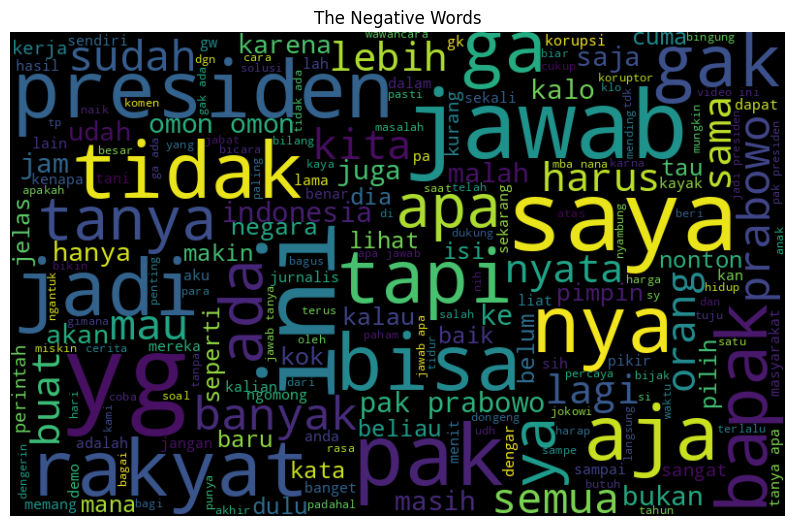

In [18]:
negative_words = ' '.join([word for sublist in df['stemming'][df['sentiment'] == 'negatif'] for word in sublist])

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Negative Words')
plt.show()

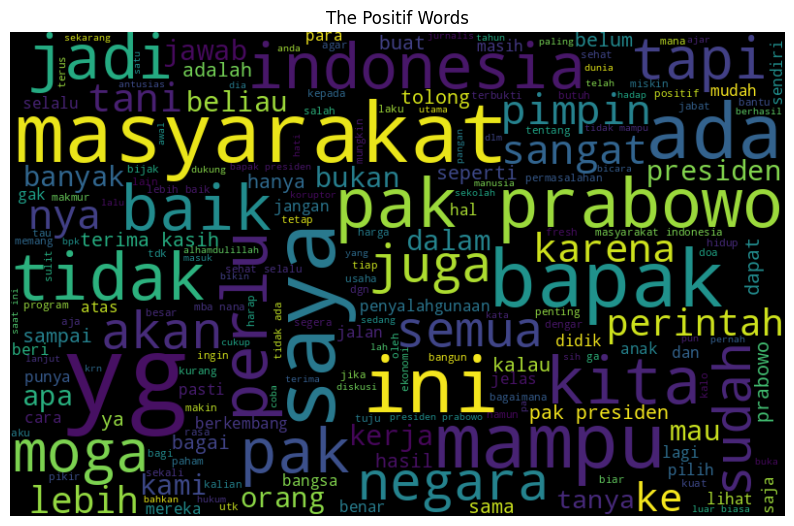

In [19]:
positif_words =' '.join([text for text in df['normalisasi'][df['sentiment'] == 'positif']])

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(positif_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Positif Words')
plt.show()

In [24]:
x = df['normalisasi']  # Teks hasil preprocessing
y = df['label']        # Label numerik: 0=Negatif, 1=Netral, 2=Positif

In [25]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x,y, test_size=0.2, random_state=42, stratify=y, shuffle=True,)

# **PEMBOBOTAN TF-IDF**

In [41]:
Tfidf_vect = TfidfVectorizer(max_features=3000)
Tfidf_vect.fit(x_train)   # Fit hanya di data training

Train_X_Tfidf = Tfidf_vect.transform(x_train)
Test_X_Tfidf = Tfidf_vect.transform(x_test)

In [42]:
Train_X_Tfidf.shape

(4797, 3000)

In [43]:
y_train.shape

(4797,)

In [44]:
print(Train_X_Tfidf)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 56755 stored elements and shape (4797, 3000)>
  Coords	Values
  (0, 18)	0.354413973519812
  (0, 1104)	0.34185657036968353
  (0, 1770)	0.4070973642487152
  (0, 2308)	0.7692831446812834
  (1, 329)	0.15631704989988113
  (1, 762)	0.2222561665855149
  (1, 836)	0.18395184317620483
  (1, 838)	0.24209331952245994
  (1, 925)	0.1587976770846412
  (1, 1077)	0.17276890457760466
  (1, 1078)	0.11776686623242967
  (1, 1284)	0.249624168755064
  (1, 1381)	0.14272174505342433
  (1, 1691)	0.20501636407239773
  (1, 1790)	0.22418520013574877
  (1, 1801)	0.29060977681032185
  (1, 2001)	0.20389437173738983
  (1, 2243)	0.16986844217256944
  (1, 2361)	0.28272607640086467
  (1, 2712)	0.1877765615592806
  (1, 2881)	0.5654521528017293
  (2, 770)	0.2151233792671282
  (2, 954)	0.4831856151857712
  (2, 1104)	0.17523647223674205
  (2, 1296)	0.3154173576822433
  :	:
  (4794, 2195)	0.25701939817741204
  (4794, 2581)	0.3354618132370944
  (4794, 2722)	0.331833

In [45]:
print(Test_X_Tfidf)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 13926 stored elements and shape (1200, 3000)>
  Coords	Values
  (0, 13)	0.42122639651996174
  (0, 576)	0.44718785401661254
  (0, 1041)	0.200407463581012
  (0, 1950)	0.4330557339944843
  (0, 2290)	0.35981417145389594
  (0, 2480)	0.5151938352807561
  (1, 857)	0.9008174128328156
  (1, 1032)	0.43419809849559776
  (2, 947)	1.0
  (3, 592)	0.27648047906773
  (3, 645)	0.2741952739319399
  (3, 1001)	0.643258168165978
  (3, 1223)	0.24501140263330673
  (3, 1503)	0.16327242804163566
  (3, 1790)	0.3187203002870896
  (3, 1895)	0.34923519281063653
  (3, 1973)	0.31597782597557333
  (3, 2720)	0.15657623106921792
  (4, 21)	0.6289556013880894
  (4, 369)	0.2705438072837725
  (4, 389)	0.26557559482104515
  (4, 1093)	0.24393602399348951
  (4, 1344)	0.2506686863588302
  (4, 1525)	0.1739506011609293
  (4, 1910)	0.2529595851978555
  :	:
  (1195, 1839)	0.5634232644561729
  (1195, 2252)	0.3501187420887393
  (1195, 2720)	0.17538150672772498
  (1196, 25

# **RANDOM FOREAST**

In [46]:
hyperparameters = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}
rf = RandomForestClassifier(random_state=42)
rf_tuned = GridSearchCV(estimator=rf, param_grid=hyperparameters,
                        cv=5, scoring='accuracy', n_jobs=-1)

In [47]:
rf_tuned.fit(Train_X_Tfidf, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20], 'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy')

In [50]:
filename = 'model_rf_AS.pkl'
pickle.dump(rf_tuned.best_estimator_, open(filename, 'wb'))

In [51]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(Test_X_Tfidf, y_test)
print(result)

0.7733333333333333


# **EVALUASI**

In [59]:
y_pred = loaded_model.predict(Test_X_Tfidf)

print("RF Accuracy Score = ", accuracy_score(y_test, y_pred)*100)
print("RF Precision Score = ", precision_score(y_test, y_pred, average='weighted')*100)
print("RF Recall Score = ", recall_score(y_test, y_pred, average='weighted')*100)
print("RF F1 Score = ", f1_score(y_test, y_pred, average='weighted')*100)

RF Accuracy Score =  77.33333333333333
RF Precision Score =  82.28377320811744
RF Recall Score =  77.33333333333333
RF F1 Score =  70.00328814993827


In [60]:
report = classification_report(y_test, y_pred)
print(report) # print classification_report

              precision    recall  f1-score   support

           0       0.77      1.00      0.87       888
           1       1.00      0.06      0.12       159
           2       0.97      0.20      0.34       153

    accuracy                           0.77      1200
   macro avg       0.91      0.42      0.44      1200
weighted avg       0.82      0.77      0.70      1200



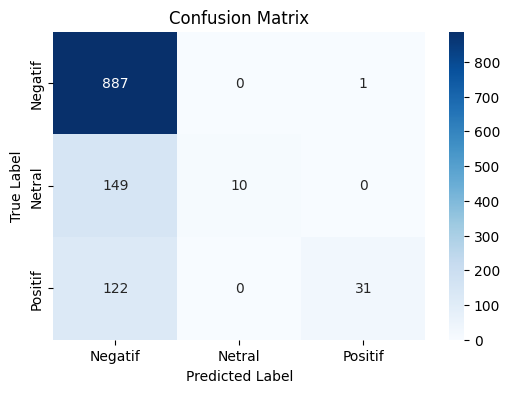

In [61]:
cm = confusion_matrix(y_test, y_pred)

label = ['Negatif', 'Netral', 'Positif']

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label, yticklabels=label)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()